# Create cutouts and sigma maps for 3D HST dataset
- Dec 22/2020: Make cutouts for COSMOS, AEGIS, GOODS-S, GOODS-N, UDS

In [21]:
# https://github.com/Grillard/GalfitPyWrap may be useful for setting up inputs
import sys
sys.path.insert(0,'/data/emiln/XLSSU122/analysis/galfit/GalfitPyWrap')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table, hstack, join
import copy
from __future__ import division
import fnmatch
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load 3DHST Master Catalog

In [7]:
# Load master catalog
master_cat = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/catalogs/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat'
master_df = pd.read_csv(master_cat,header=0,delim_whitespace=True,skiprows=[1])
master_df.columns.values

array(['id', 'field', 'ra', 'dec', 'x', 'y', 'z_spec', 'z_peak',
       'faper_F140W', 'eaper_F140W', 'faper_F160W', 'eaper_F160W',
       'f_F606W', 'e_F606W', 'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W',
       'f_F140W', 'e_F140W', 'f_F160W', 'e_F160W', 'tot_cor',
       'kron_radius', 'a_image', 'b_image', 'flux_radius', 'fwhm_image',
       'flags', 'f140w_flag', 'star_flag', 'use_phot', 'near_star',
       'nexp_f125w', 'nexp_f140w', 'nexp_f160w', 'lmass', 'Av'],
      dtype=object)

In [18]:
# Filter master catalog
zthresh=0.1
fdf = master_df
fdf['F140W'] = 25.0 - 2.5 * np.log10(fdf['f_F140W'])
fdf = fdf[(fdf['F140W']<24) & (fdf['F140W']>15)]
# hst_df = hst_df[hst_df['star_flag']==0] # remove stars
print len(fdf)
fdf = fdf[fdf['use_phot']==1]
print len(fdf)
fdf = fdf[fdf['flags']<2]
print len(fdf)
fdf['z'] = fdf.apply(lambda x: x.z_spec if x.z_spec > 0 else x.z_peak, axis=1)
fdf = fdf[abs(fdf['z']-2.0)<zthresh]
print len(fdf)
# print fhst_df['z_spec']
# print len(fdf[fdf['field']=='COSMOS'])

24018
21040
12795
531


## Make batches by field

In [19]:
cosmos_df = fdf[fdf['field']=='COSMOS']
aegis_df = fdf[fdf['field']=='AEGIS']
goodsn_df = fdf[fdf['field']=='GOODS-N']
goodss_df = fdf[fdf['field']=='GOODS-S']
uds_df = fdf[fdf['field']=='UDS']

print len(cosmos_df), len(aegis_df), len(goodsn_df), len(goodss_df), len(uds_df)

146 106 104 74 101


## Make cutouts by batch

### COSMOS

In [20]:
hst_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/cosmos_3dhst_v4.0_f140w/cosmos_3dhst.v4.0.F140W_orig_sci.fits.gz'
hst_exp_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/cosmos_3dhst_v4.0_f140w/cosmos_3dhst.v4.0.F140W_exp.fits.gz'
hst_wht_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/cosmos_3dhst_v4.0_f140w/cosmos_3dhst.v4.0.F140W_orig_wht.fits.gz'

hst_hdulist = fits.open(hst_file)
full_wcs = wcs.WCS(hst_hdulist[0].header)

exp_hdulist = fits.open(hst_exp_file)
wht_hdulist = fits.open(hst_wht_file)

In [22]:
# For each object
# Make a directory to store data products
# Create image cutout with same header and updated wcs info
# Create cutout sigma image in units of cps

w=400
df = cosmos_df

# df = cos_df
for idx, r in df.iterrows():
    ra = r.ra
    dec = r.dec
    pixcrd = full_wcs.wcs_world2pix(ra,dec, 1)
    print pixcrd
    X = int(pixcrd[0])
    Y = int(pixcrd[1])
    ID = int(r['id'])
    
    print "ID", ID
    print "RA:",ra
    print "DEC:",dec
    print "Initial X:", X
    print "Initial Y:", Y
    
    tdir = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/galfit_results/COSMOS/'+str(ID)
    try:
        os.mkdir(tdir)
    except:
        print("Directory already exists.")

    print("Making data, exp, rms, wht cutouts")
    wmapcut = full_wcs[Y-w:Y+w,X-w:X+w]
    datacut = hst_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    expcut = exp_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    whtcut = wht_hdulist[0].data[Y-w:Y+w,X-w:X+w] # inverse variance
    rmscut = np.sqrt(1./whtcut) # stdev per pixel

    print expcut.shape
    print datacut.shape
    print rmscut.shape
    print whtcut.shape

    newdata = datacut # this is in ELECTRONS/s

    newcounts_meanexp = newdata * np.mean(expcut)
    nonzero_counts_meanexp = newcounts_meanexp.copy()
    nonzero_counts_meanexp[nonzero_counts_meanexp<0] = 0

    # RMS + POISSON
    newsigma_rms_meanexp = rmscut + np.sqrt(nonzero_counts_meanexp)/np.mean(expcut)

    new_cos_hdu = fits.PrimaryHDU(newdata)
    new_cos_hdul = fits.HDUList([new_cos_hdu])
    new_cos_hdul[0].header = hst_hdulist[0].header
    new_cos_hdul[0].header.update(wmapcut.to_header()) 
    new_cos_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_cos_filename = tdir+'/data_cps.fits'
    new_cos_hdul.writeto(new_cos_filename, clobber=True)
    

    new_sigma_hdu = fits.PrimaryHDU(newsigma_rms_meanexp)
    new_sigma_hdul = fits.HDUList([new_sigma_hdu])
    new_sigma_hdul[0].header = copy.deepcopy(wht_hdulist[0].header)
    new_sigma_hdul[0].header.update(wmapcut.to_header()) 
    new_sigma_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_sigma_filename = tdir+'/sigma_rms_meanexp_cps.fits'
    new_sigma_hdul.writeto(new_sigma_filename, clobber=True)

00)
(800, 800)
(800, 800)
[array(7698.94165508), array(13139.3678286)]
ID 8539
RA: 150.11134338
DEC: 2.26662087
Initial X: 7698
Initial Y: 13139
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(8955.89203431), array(13156.56226388)]
ID 8587
RA: 150.09037781
DEC: 2.26690722
Initial X: 8955
Initial Y: 13156
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(7050.34016454), array(13228.18912366)]
ID 8617
RA: 150.12216187
DEC: 2.26810122
Initial X: 7050
Initial Y: 13228
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(3222.77235087), array(13257.65721476)]
ID 8752
RA: 150.18600464
DEC: 2.26859069
Initial X: 3222
Initial Y: 13257
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(11045.31488465), array(13346.13875355)]
ID 8898
RA: 150.05552673
DEC: 2.27006578
Initial X: 11045
Initial Y: 13346
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)


### AEGIS

In [24]:
hst_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/aegis_3dhst_v4.0_f140w/aegis_3dhst.v4.0.F140W_orig_sci.fits.gz'
hst_exp_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/aegis_3dhst_v4.0_f140w/aegis_3dhst.v4.0.F140W_exp.fits.gz'
hst_wht_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/aegis_3dhst_v4.0_f140w/aegis_3dhst.v4.0.F140W_orig_wht.fits.gz'

hst_hdulist = fits.open(hst_file)
full_wcs = wcs.WCS(hst_hdulist[0].header)

exp_hdulist = fits.open(hst_exp_file)
wht_hdulist = fits.open(hst_wht_file)

In [26]:
# For each object
# Make a directory to store data products
# Create image cutout with same header and updated wcs info
# Create cutout sigma image in units of cps

w=400
df = aegis_df

for idx, r in df.iterrows():
    ra = r.ra
    dec = r.dec
    pixcrd = full_wcs.wcs_world2pix(ra,dec, 1)
    print pixcrd
    X = int(pixcrd[0])
    Y = int(pixcrd[1])
    ID = int(r['id'])
    
    print "ID", ID
    print "RA:",ra
    print "DEC:",dec
    print "Initial X:", X
    print "Initial Y:", Y
    
    tdir = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/galfit_results/AEGIS/'+str(ID)
    try:
        os.mkdir(tdir)
    except:
        print("Directory already exists.")

    print("Making data, exp, rms, wht cutouts")
    wmapcut = full_wcs[Y-w:Y+w,X-w:X+w]
    datacut = hst_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    expcut = exp_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    whtcut = wht_hdulist[0].data[Y-w:Y+w,X-w:X+w] # inverse variance
    rmscut = np.sqrt(1./whtcut) # stdev per pixel

    print expcut.shape
    print datacut.shape
    print rmscut.shape
    print whtcut.shape

    newdata = datacut # this is in ELECTRONS/s

    newcounts_meanexp = newdata * np.mean(expcut)
    nonzero_counts_meanexp = newcounts_meanexp.copy()
    nonzero_counts_meanexp[nonzero_counts_meanexp<0] = 0

    # RMS + POISSON
    newsigma_rms_meanexp = rmscut + np.sqrt(nonzero_counts_meanexp)/np.mean(expcut)

    new_cos_hdu = fits.PrimaryHDU(newdata)
    new_cos_hdul = fits.HDUList([new_cos_hdu])
    new_cos_hdul[0].header = hst_hdulist[0].header
    new_cos_hdul[0].header.update(wmapcut.to_header()) 
    new_cos_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_cos_filename = tdir+'/data_cps.fits'
    new_cos_hdul.writeto(new_cos_filename, clobber=True)
    

    new_sigma_hdu = fits.PrimaryHDU(newsigma_rms_meanexp)
    new_sigma_hdul = fits.HDUList([new_sigma_hdu])
    new_sigma_hdul[0].header = copy.deepcopy(wht_hdulist[0].header)
    new_sigma_hdul[0].header.update(wmapcut.to_header()) 
    new_sigma_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_sigma_filename = tdir+'/sigma_rms_meanexp_cps.fits'
    new_sigma_hdul.writeto(new_sigma_filename, clobber=True)

321463)]
ID 3455
RA: 215.05856323
DEC: 52.90653992
Initial X: 17892
Initial Y: 3747
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(15540.12408796), array(3840.18396532)]
ID 3952
RA: 215.09884644
DEC: 52.93734741
Initial X: 15540
Initial Y: 3840
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(18225.82576998), array(3842.53114845)]
ID 4035
RA: 215.05058289
DEC: 52.90333557
Initial X: 18225
Initial Y: 3842
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(24793.1770668), array(3955.29858442)]
ID 4679
RA: 214.93063354
DEC: 52.82123947
Initial X: 24793
Initial Y: 3955
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(15341.93368225), array(3984.88765731)]
ID 4775
RA: 215.09936523
DEC: 52.94142532
Initial X: 15341
Initial Y: 3984
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(16742.40877751), array(4131.892

### GOODS-N

In [27]:
hst_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/goodsn_3dhst_v4.0_f140w/goodsn_3dhst.v4.0.F140W_orig_sci.fits.gz'
hst_exp_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/goodsn_3dhst_v4.0_f140w/goodsn_3dhst.v4.0.F140W_exp.fits.gz'
hst_wht_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/goodsn_3dhst_v4.0_f140w/goodsn_3dhst.v4.0.F140W_orig_wht.fits.gz'

hst_hdulist = fits.open(hst_file)
full_wcs = wcs.WCS(hst_hdulist[0].header)

exp_hdulist = fits.open(hst_exp_file)
wht_hdulist = fits.open(hst_wht_file)

In [28]:
# For each object
# Make a directory to store data products
# Create image cutout with same header and updated wcs info
# Create cutout sigma image in units of cps

w=400
df = goodsn_df

# df = cos_df
for idx, r in df.iterrows():
    ra = r.ra
    dec = r.dec
    pixcrd = full_wcs.wcs_world2pix(ra,dec, 1)
    print pixcrd
    X = int(pixcrd[0])
    Y = int(pixcrd[1])
    ID = int(r['id'])
    
    print "ID", ID
    print "RA:",ra
    print "DEC:",dec
    print "Initial X:", X
    print "Initial Y:", Y
    
    tdir = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/galfit_results/GOODSN/'+str(ID)
    try:
        os.mkdir(tdir)
    except:
        print("Directory already exists.")

    print("Making data, exp, rms, wht cutouts")
    wmapcut = full_wcs[Y-w:Y+w,X-w:X+w]
    datacut = hst_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    expcut = exp_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    whtcut = wht_hdulist[0].data[Y-w:Y+w,X-w:X+w] # inverse variance
    rmscut = np.sqrt(1./whtcut) # stdev per pixel

    print expcut.shape
    print datacut.shape
    print rmscut.shape
    print whtcut.shape

    newdata = datacut # this is in ELECTRONS/s

    newcounts_meanexp = newdata * np.mean(expcut)
    nonzero_counts_meanexp = newcounts_meanexp.copy()
    nonzero_counts_meanexp[nonzero_counts_meanexp<0] = 0

    # RMS + POISSON
    newsigma_rms_meanexp = rmscut + np.sqrt(nonzero_counts_meanexp)/np.mean(expcut)

    new_cos_hdu = fits.PrimaryHDU(newdata)
    new_cos_hdul = fits.HDUList([new_cos_hdu])
    new_cos_hdul[0].header = hst_hdulist[0].header
    new_cos_hdul[0].header.update(wmapcut.to_header()) 
    new_cos_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_cos_filename = tdir+'/data_cps.fits'
    new_cos_hdul.writeto(new_cos_filename, clobber=True)
    

    new_sigma_hdu = fits.PrimaryHDU(newsigma_rms_meanexp)
    new_sigma_hdul = fits.HDUList([new_sigma_hdu])
    new_sigma_hdul[0].header = copy.deepcopy(wht_hdulist[0].header)
    new_sigma_hdul[0].header.update(wmapcut.to_header()) 
    new_sigma_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_sigma_filename = tdir+'/sigma_rms_meanexp_cps.fits'
    new_sigma_hdul.writeto(new_sigma_filename, clobber=True)

4), array(3381.72753979)]
ID 961
RA: 189.19918823
DEC: 62.12425613
Initial X: 11166
Initial Y: 3381
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(11516.59325207), array(3655.89348442)]
ID 1227
RA: 189.18669128
DEC: 62.12882233
Initial X: 11516
Initial Y: 3655
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(12315.08662085), array(3792.08396805)]
ID 1371
RA: 189.15821838
DEC: 62.13108063
Initial X: 12315
Initial Y: 3792
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(13048.61419058), array(3794.85996743)]
ID 1385
RA: 189.13206482
DEC: 62.13111115
Initial X: 13048
Initial Y: 3794
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(10326.76815018), array(4235.043544)]
ID 1886
RA: 189.22911072
DEC: 62.13848114
Initial X: 10326
Initial Y: 4235
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(14370.3377661), 

### GOODS-S

In [29]:
hst_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/goodss_3dhst_v4.0_f140w/goodss_3dhst.v4.0.F140W_orig_sci.fits.gz'
hst_exp_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/goodss_3dhst_v4.0_f140w/goodss_3dhst.v4.0.F140W_exp.fits.gz'
hst_wht_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/goodss_3dhst_v4.0_f140w/goodss_3dhst.v4.0.F140W_orig_wht.fits.gz'

hst_hdulist = fits.open(hst_file)
full_wcs = wcs.WCS(hst_hdulist[0].header)

exp_hdulist = fits.open(hst_exp_file)
wht_hdulist = fits.open(hst_wht_file)

In [30]:
# For each object
# Make a directory to store data products
# Create image cutout with same header and updated wcs info
# Create cutout sigma image in units of cps

w=400
df = goodss_df

# df = cos_df
for idx, r in df.iterrows():
    ra = r.ra
    dec = r.dec
    pixcrd = full_wcs.wcs_world2pix(ra,dec, 1)
    print pixcrd
    X = int(pixcrd[0])
    Y = int(pixcrd[1])
    ID = int(r['id'])
    
    print "ID", ID
    print "RA:",ra
    print "DEC:",dec
    print "Initial X:", X
    print "Initial Y:", Y
    
    tdir = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/galfit_results/GOODSS/'+str(ID)
    try:
        os.mkdir(tdir)
    except:
        print("Directory already exists.")

    print("Making data, exp, rms, wht cutouts")
    wmapcut = full_wcs[Y-w:Y+w,X-w:X+w]
    datacut = hst_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    expcut = exp_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    whtcut = wht_hdulist[0].data[Y-w:Y+w,X-w:X+w] # inverse variance
    rmscut = np.sqrt(1./whtcut) # stdev per pixel

    print expcut.shape
    print datacut.shape
    print rmscut.shape
    print whtcut.shape

    newdata = datacut # this is in ELECTRONS/s

    newcounts_meanexp = newdata * np.mean(expcut)
    nonzero_counts_meanexp = newcounts_meanexp.copy()
    nonzero_counts_meanexp[nonzero_counts_meanexp<0] = 0

    # RMS + POISSON
    newsigma_rms_meanexp = rmscut + np.sqrt(nonzero_counts_meanexp)/np.mean(expcut)

    new_cos_hdu = fits.PrimaryHDU(newdata)
    new_cos_hdul = fits.HDUList([new_cos_hdu])
    new_cos_hdul[0].header = hst_hdulist[0].header
    new_cos_hdul[0].header.update(wmapcut.to_header()) 
    new_cos_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_cos_filename = tdir+'/data_cps.fits'
    new_cos_hdul.writeto(new_cos_filename, clobber=True)
    

    new_sigma_hdu = fits.PrimaryHDU(newsigma_rms_meanexp)
    new_sigma_hdul = fits.HDUList([new_sigma_hdu])
    new_sigma_hdul[0].header = copy.deepcopy(wht_hdulist[0].header)
    new_sigma_hdul[0].header.update(wmapcut.to_header()) 
    new_sigma_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_sigma_filename = tdir+'/sigma_rms_meanexp_cps.fits'
    new_sigma_hdul.writeto(new_sigma_filename, clobber=True)

[array(9133.95145006), array(3200.00612688)]
ID 1000
RA: 53.14475632
DEC: -27.92842865
Initial X: 9133
Initial Y: 3200
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(10186.11488358), array(4004.74741768)]
ID 1971
RA: 53.12490845
DEC: -27.91501808
Initial X: 10186
Initial Y: 4004
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(7482.57585811), array(4144.21247259)]
ID 2174
RA: 53.17589951
DEC: -27.91268349
Initial X: 7482
Initial Y: 4144
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(5522.55586906), array(4653.01653831)]
ID 2974
RA: 53.21286011
DEC: -27.90418434
Initial X: 5522
Initial Y: 4653
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(12430.18159176), array(4932.17412795)]
ID 3518
RA: 53.0825882
DEC: -27.89955521
Initial X: 12430
Initial Y: 4932
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(

### UDS

In [31]:
hst_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/uds_3dhst_v4.0_f140w/uds_3dhst.v4.0.F140W_orig_sci.fits.gz'
hst_exp_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/uds_3dhst_v4.0_f140w/uds_3dhst.v4.0.F140W_exp.fits.gz'
hst_wht_file = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Raw/uds_3dhst_v4.0_f140w/uds_3dhst.v4.0.F140W_orig_wht.fits.gz'

hst_hdulist = fits.open(hst_file)
full_wcs = wcs.WCS(hst_hdulist[0].header)

exp_hdulist = fits.open(hst_exp_file)
wht_hdulist = fits.open(hst_wht_file)

In [32]:
# For each object
# Make a directory to store data products
# Create image cutout with same header and updated wcs info
# Create cutout sigma image in units of cps

w=400
df = uds_df

# df = cos_df
for idx, r in df.iterrows():
    ra = r.ra
    dec = r.dec
    pixcrd = full_wcs.wcs_world2pix(ra,dec, 1)
    print pixcrd
    X = int(pixcrd[0])
    Y = int(pixcrd[1])
    ID = int(r['id'])
    
    print "ID", ID
    print "RA:",ra
    print "DEC:",dec
    print "Initial X:", X
    print "Initial Y:", Y
    
    tdir = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/galfit_results/UDS/'+str(ID)
    try:
        os.mkdir(tdir)
    except:
        print("Directory already exists.")

    print("Making data, exp, rms, wht cutouts")
    wmapcut = full_wcs[Y-w:Y+w,X-w:X+w]
    datacut = hst_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    expcut = exp_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    whtcut = wht_hdulist[0].data[Y-w:Y+w,X-w:X+w] # inverse variance
    rmscut = np.sqrt(1./whtcut) # stdev per pixel

    print expcut.shape
    print datacut.shape
    print rmscut.shape
    print whtcut.shape

    newdata = datacut # this is in ELECTRONS/s

    newcounts_meanexp = newdata * np.mean(expcut)
    nonzero_counts_meanexp = newcounts_meanexp.copy()
    nonzero_counts_meanexp[nonzero_counts_meanexp<0] = 0

    # RMS + POISSON
    newsigma_rms_meanexp = rmscut + np.sqrt(nonzero_counts_meanexp)/np.mean(expcut)

    new_cos_hdu = fits.PrimaryHDU(newdata)
    new_cos_hdul = fits.HDUList([new_cos_hdu])
    new_cos_hdul[0].header = hst_hdulist[0].header
    new_cos_hdul[0].header.update(wmapcut.to_header()) 
    new_cos_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_cos_filename = tdir+'/data_cps.fits'
    new_cos_hdul.writeto(new_cos_filename, clobber=True)
    

    new_sigma_hdu = fits.PrimaryHDU(newsigma_rms_meanexp)
    new_sigma_hdul = fits.HDUList([new_sigma_hdu])
    new_sigma_hdul[0].header = copy.deepcopy(wht_hdulist[0].header)
    new_sigma_hdul[0].header.update(wmapcut.to_header()) 
    new_sigma_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_sigma_filename = tdir+'/sigma_rms_meanexp_cps.fits'
    new_sigma_hdul.writeto(new_sigma_filename, clobber=True)

nitial Y: 1903
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(15085.54298697), array(2104.38470079)]
ID 1831
RA: 34.35461426
DEC: -5.27159977
Initial X: 15085
Initial Y: 2104
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(12850.39890578), array(2450.85856935)]
ID 3302
RA: 34.39202499
DEC: -5.26582718
Initial X: 12850
Initial Y: 2450
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(15359.30738744), array(2550.50977948)]
ID 3694
RA: 34.35003281
DEC: -5.26416397
Initial X: 15359
Initial Y: 2550
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(15607.29108042), array(2657.77520067)]
ID 4343
RA: 34.34588242
DEC: -5.26237583
Initial X: 15607
Initial Y: 2657
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(19732.84708754), array(2727.70157571)]
ID 4571
RA: 34.27683258
DEC: -5.26119995
Initial X: 19732
Initia

____________
# OLD
__________

In [2]:
# Load 3d HST catalog
hst_cat = '/data/emiln/XLSSU122/analysis/3dhst/catalogs/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat'
hst_df = pd.read_csv(hst_cat,header=0,delim_whitespace=True,skiprows=[1,2,3])
# hst_df2 = cos_df[cos_df.columns[:-1]]
# cos_df2.columns = cos_df.columns[1:]
# cos_df = cos_df2
# print len(cos_df)
# cos_df = cos_df[(cos_df['mag']<23) & (cos_df['f']==0)] # Let's focus on objects brighter than mag 23 for now
# cos_df = cos_df[(cos_df['mag']<21) & (cos_df['f']==0)] # Let's focus on objects brighter than mag 23 for now
# cos_df = cos_df[(cos_df['dn']/cos_df['n'])<1] # Filter out objects with > 100% error
# # f=0 are all "good fits" https://users.ugent.be/~avdrwel/data/readme_candels.txt
# print len(cos_df)
# cos_df.columns.values
hst_df.columns.values
hst_df

,id,x,y,ra,dec,faper_F160W,eaper_F160W,faper_F140W,eaper_F140W,f_F160W,...,IRAC2_contam,IRAC3_contam,IRAC4_contam,contam_flag,f140w_flag,use_phot,near_star,nexp_f125w,nexp_f140w,nexp_f160w
0,2,10083.4,7285.7,150.071579,2.169060,2.158842,0.165525,-61.84459,-61.84459,3.455845,...,1.744,-99.000,-99.000,1,0,0,0,1.0,0.0,1.0
1,3,9847.2,7529.0,150.075516,2.173114,18.137190,0.045990,-30.69575,-30.69575,58.496120,...,0.004,0.014,0.028,0,0,1,0,6.0,0.0,6.0
2,4,10277.1,7326.9,150.068344,2.169745,0.539666,0.096470,-81.87084,-81.87084,0.652575,...,0.002,-99.000,-99.000,0,0,1,0,2.0,0.0,2.0
3,5,10090.1,7380.9,150.071457,2.170646,0.727406,0.068492,-87.35809,-87.35809,0.824345,...,0.001,-99.000,-99.000,0,0,1,0,4.0,0.0,4.0
4,6,10201.7,7388.2,150.069595,2.170768,0.393757,0.054795,-79.56773,-79.56772,0.489922,...,-0.763,-99.000,-99.000,0,0,1,0,4.0,0.0,4.0
5,7,10276.0,7405.9,150.068359,2.171062,3.034307,0.067463,-74.09850,-74.09851,4.054014,...,0.485,-99.000,-99.000,1,0,0,0,4.0,0.0,4.0
6,8,10227.8,7404.5,150.069168,2.171038,0.340244,0.055854,-70.89510,-70.89510,0.475127,...,2.516,-99.000,-99.000,1,0,1,0,4.0,0.0,4.0
7,9,9579.7,7404.1,150.079971,2.171032,0.683393,0.117511,-52.39865,-52.39865,1.291177,...,1.313,-99.000,-99.000,1,0,1,0,2.0,0.0,2.0
8,10,10263.6,7434.9,150.068573,2.171545,4.488521,0.057601,-67.38472,-67.38472,6.594427,...,0.224,-99.000,-99.000,0,0,0,0,4.0,0.0,4.0
9,11,10025.4,7422.1,150.072540,2.171333,0.452502,0.056167,-44.57120,-44.57120,1.005081,...,0.002,-99.000,-99.000,0,0,1,0,4.0,0.0,4.0


In [3]:
z_df = pd.read_csv('/data/emiln/XLSSU122/analysis/3dhst/catalogs/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst_v4.1.5_catalogs/cosmos_3dhst.v4.1.5.zbest.fout',\
                   delim_whitespace=True)
mdf = hst_df.merge(z_df,on='id',how='inner')

In [8]:
# Filter 3D HST catalog
# zthresh=0.1
zthresh=0.3
print len(mdf)
# fhst_df = hst_df[(hst_df['faper_F140W']<25) & (hst_df['faper_F140W']>15)]
mdf['F140W'] = 25.0 - 2.5 * np.log10(mdf['f_F140W'])
fhst_df = mdf[(mdf['F140W']<24) & (mdf['F140W']>15)]
# hst_df = hst_df[hst_df['star_flag']==0] # remove stars
print len(fhst_df)
fhst_df = fhst_df[fhst_df['use_phot']==1]
print len(fhst_df)
fhst_df = fhst_df[fhst_df['flags']<2]
print len(fhst_df)
fhst_df = fhst_df[abs(fhst_df['z']-2.0)<zthresh]
print len(fhst_df)
# print fhst_df['z_spec']
fhst_df

33878
4996
4234
2898
433


,id,x,y,ra,dec,faper_F160W,eaper_F160W,faper_F140W,eaper_F140W,f_F160W,...,ltau,metal,lage,Av,lmass,lsfr,lssfr,la2t,chi2,F140W
689,691,8095.2,8386.8,150.104736,2.187411,2.148079,0.042300,1.848545,0.085333,3.666291,...,7.0,0.02,8.0,1.0,9.84,-1.33,-11.17,1.0,1.770,23.752483
1192,1194,8512.3,8663.4,150.097778,2.192021,2.206952,0.029508,2.263605,0.085193,3.372494,...,7.6,0.02,8.3,0.3,9.52,-0.09,-9.61,0.7,1.510,23.652603
2060,2062,6482.1,9175.5,150.131638,2.200557,1.875272,0.052047,1.243067,0.079174,4.454429,...,8.2,0.02,8.9,0.5,10.32,0.16,-10.17,0.7,2.270,23.824444
2138,2140,5526.6,9205.7,150.147583,2.201060,1.852057,0.043311,1.432984,0.142042,3.701528,...,8.4,0.02,8.9,0.6,10.08,0.52,-9.56,0.5,1.120,23.857580
2300,2302,10343.8,9425.7,150.067230,2.204726,6.088034,0.035499,4.717139,0.087858,15.959130,...,7.8,0.02,8.9,1.0,10.85,-2.16,-13.00,1.1,2.010,22.269473
2329,2331,6045.7,9313.5,150.138916,2.202856,2.173798,0.042267,2.087376,0.080829,3.719533,...,8.0,0.02,8.4,0.1,9.50,0.60,-8.90,0.4,1.280,23.617825
2542,2544,5230.0,9446.9,150.152527,2.205080,2.436972,0.058670,2.127133,0.081212,3.755564,...,8.2,0.02,8.3,0.6,9.45,0.99,-8.46,0.1,1.450,23.710951
2631,2633,6974.4,9481.2,150.123428,2.205652,1.558026,0.058675,1.536214,0.084350,2.767174,...,8.0,0.02,8.4,0.0,9.44,0.54,-8.90,0.4,1.920,23.910217
2710,2712,6046.0,9536.6,150.138916,2.206575,2.316963,0.042506,2.138305,0.080798,3.279080,...,8.8,0.02,8.7,0.4,9.53,0.81,-8.72,-0.1,1.450,23.797743
2714,2716,3728.2,9624.6,150.177567,2.208040,4.132455,0.041862,3.513331,0.081873,19.314090,...,9.8,0.02,9.1,1.0,10.81,1.85,-8.95,-0.7,1.260,21.961537


In [9]:
fhst_df.to_csv('/data/emiln/XLSSU122/analysis/3dhst/catalogs/merged_highz_thresh'+str(zthresh)+'_clean.cat',index=None)
# pd.read_csv('/data/emiln/XLSSU122/analysis/3dhst/catalogs/merged_highz.cat')

--------------

### Make source cutouts

In [10]:
fhst_df = pd.read_csv('/data/emiln/XLSSU122/analysis/3dhst/catalogs/merged_highz_thresh'+str(zthresh)+'_clean.cat')

In [11]:
# Load HST fits images

hst_file = '/data/emiln/XLSSU122/analysis/3dhst/cosmos_3dhst_v4.0_f140w/cosmos_3dhst.v4.0.F140W_orig_sci.fits.gz' # conv is F140W convolved to F160W PSF
# http://monoceros.astro.yale.edu/RELEASE_V4.0/3dhst_readme_v4.1.pdf
hst_exp_file = '/data/emiln/XLSSU122/analysis/3dhst/cosmos_3dhst_v4.0_f140w/cosmos_3dhst.v4.0.F140W_exp.fits.gz'
# hst_rms_file = '/data/emiln/XLSSU122/analysis/3dhst/cosmos_3dhst_v4.0_f140w/cosmos_3dhst.v4.0.F140W_orig_wht.fits.gz'
hst_wht_file = '/data/emiln/XLSSU122/analysis/3dhst/cosmos_3dhst_v4.0_f140w/cosmos_3dhst.v4.0.F140W_orig_wht.fits.gz'
# From https://iopscience.iop.org/article/10.1088/0067-0049/214/2/24/pdf:
# The inverse variance weight map is based on the flat-field reference file
# and computed dark value from the image header and the final
# weight image accounts for all background noise sources (sky
# level, read noise, dark current, etc.) but not the Poisson noise
# from the objects themselves.

hst_hdulist = fits.open(hst_file)
full_wcs = wcs.WCS(hst_hdulist[0].header)

exp_hdulist = fits.open(hst_exp_file)
# rms_hdulist = fits.open(hst_rms_file)
wht_hdulist = fits.open(hst_wht_file)

In [13]:
# For each object in fhst_df
# Make a directory to store data products
# Create image cutout with same header and updated wcs info
# Create cutout sigma image in units of cps

import copy

# exptime=1900 # https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/hlsp_candels_hst_cos-tot_readme_v1.0.pdf
w=400
# df = cos_df[cos_df['NUMBER']==886]
# df = cos_df[0:2]
# df = cos_df
df = fhst_df

# df = cos_df
for idx, r in df.iterrows():
    ra = r.ra
    dec = r.dec
    pixcrd = full_wcs.wcs_world2pix(ra,dec, 1)
    print pixcrd
    X = int(pixcrd[0])
    Y = int(pixcrd[1])
    ID = int(r['id'])
    
    print "ID", ID
    print "RA:",ra
    print "DEC:",dec
    print "Initial X:", X
    print "Initial Y:", Y
    
    # tdir = '/data/emiln/XLSSU122/analysis/3dhst/galfit_results/'+str(ID)
    tdir = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/galfit_results/'+str(ID)
    try:
        os.mkdir(tdir)
    except:
        print("Directory already exists.")

    print("Making data, exp, rms, wht cutouts")
    wmapcut = full_wcs[Y-w:Y+w,X-w:X+w]
    datacut = hst_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    expcut = exp_hdulist[0].data[Y-w:Y+w,X-w:X+w]
#     rmscut = rms_hdulist[0].data[Y-w:Y+w,X-w:X+w]
    whtcut = wht_hdulist[0].data[Y-w:Y+w,X-w:X+w] # inverse variance
    rmscut = np.sqrt(1./whtcut) # stdev per pixel
    print expcut.shape
    print datacut.shape
    print rmscut.shape
    print whtcut.shape

    newdata = datacut # this is in ELECTRONS/s
    # newexp = expcut
#     newrms = rmscut # this is in ELECTRONS/s
    # newwht = whtcut
    # newcounts = newdata * expcut 
    # newcounts2 = newdata * expcut / 2.5 # Should divide by the gain = 2.5 (e/count) to get this in counts
    
#     central_mask = np.zeros(newdata.shape)
#     xx, yy = np.meshgrid(np.arange(central_mask.shape[0]),np.arange(central_mask.shape[1]))
#     xc = newdata.shape[0]/2
#     yc = newdata.shape[1]/2
#     rthresh = r.FLUX_RADIUS_1_F125W # Mask out inner 20% light radius
#     central_mask_IDs = (xx-xc)**2+(yy-yc)**2 < rthresh**2
#     central_mask[central_mask_IDs] = 1
    
    # nonzero_counts = newcounts.copy()
    # nonzero_counts[nonzero_counts<0] = 0
    
    # nonzero_counts2 = newcounts2.copy()
    # nonzero_counts2[nonzero_counts2<0] = 0
    
    newcounts_meanexp = newdata * np.mean(expcut)
    nonzero_counts_meanexp = newcounts_meanexp.copy()
    nonzero_counts_meanexp[nonzero_counts_meanexp<0] = 0
    # print np.min(nonzero_counts)
    
    # newcounts_meanexp2 = newdata * np.mean(expcut) / 2.5
    # nonzero_counts_meanexp2 = newcounts_meanexp2.copy()
    # nonzero_counts_meanexp2[nonzero_counts_meanexp2<0] = 0
    
#     newsigma = (np.sqrt(1./rmscut) + np.sqrt(nonzero_counts))/expcut
#     newsigma_meanexp = (np.sqrt(1./rmscut) + np.sqrt(nonzero_counts_meanexp))/np.mean(expcut)
#     newsigma_counts = np.sqrt(rmscut * np.mean(expcut)) / 2.5 + np.sqrt(nonzero_counts_meanexp2)
    
    # RMS + POISSON
    newsigma_rms_meanexp = rmscut + np.sqrt(nonzero_counts_meanexp)/np.mean(expcut)
#     newsigma_counts = np.sqrt(rmscut * np.mean(expcut)) / 2.5 + np.sqrt(nonzero_counts_meanexp2)
    
#     newsigma = (np.sqrt(1./newwht) + np.sqrt(nonzero_counts))/expcut
#     newsigma_meanexp = (np.sqrt(1./newwht) + np.sqrt(nonzero_counts_meanexp))/np.mean(expcut)
#     newsigma_counts = (np.sqrt(1./newwht) + np.sqrt(nonzero_counts)) / 2.5

    
#     new_cos_hdu = fits.PrimaryHDU(newdata)
#     new_cos_hdul = fits.HDUList([new_cos_hdu])
#     new_cos_hdul[0].header = cos_hdulist[0].header
#     new_cos_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_cos_filename = tdir+'/cutout.fits'
#     new_cos_hdul.writeto(new_cos_filename, clobber=True)

##### Oct 10 ####

    new_cos_hdu = fits.PrimaryHDU(newdata)
    new_cos_hdul = fits.HDUList([new_cos_hdu])
    new_cos_hdul[0].header = hst_hdulist[0].header
    new_cos_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
    new_cos_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_cos_filename = tdir+'/data_cps.fits'
    new_cos_hdul.writeto(new_cos_filename, clobber=True)
    
#     new_cos_hdu = fits.PrimaryHDU(central_mask)
#     new_cos_hdul = fits.HDUList([new_cos_hdu])
#     new_cos_hdul[0].header = cos_hdulist[0].header
#     new_cos_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_cos_hdul[0].header['EXPTIME'] = 1 #CPS
#     new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
#     new_cos_filename = tdir+'/20p_mask.fits'
#     new_cos_hdul.writeto(new_cos_filename, clobber=True)

    new_sigma_hdu = fits.PrimaryHDU(newsigma_rms_meanexp)
    new_sigma_hdul = fits.HDUList([new_sigma_hdu])
    new_sigma_hdul[0].header = copy.deepcopy(wht_hdulist[0].header)
    new_sigma_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
    new_sigma_hdul[0].header['EXPTIME'] = 1 #CPS
    new_cos_hdul[0].header['GAIN'] = 2.5 #CPS
    new_sigma_filename = tdir+'/sigma_rms_meanexp_cps.fits'
    new_sigma_hdul.writeto(new_sigma_filename, clobber=True)

####################
    
#     new_sigma_hdu = fits.PrimaryHDU(newsigma_counts)
#     new_sigma_hdul = fits.HDUList([new_sigma_hdu])
#     new_sigma_hdul[0].header = copy.deepcopy(rms_hdulist[0].header)
#     new_sigma_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_filename = tdir+'/sigma_meanexp_counts.fits'
#     new_sigma_hdul.writeto(new_sigma_filename, clobber=True)

#     new_sigma_hdu3 = fits.PrimaryHDU(newsigma_counts)
#     new_sigma_hdul3 = fits.HDUList([new_sigma_hdu3])
#     new_sigma_hdul3[0].header = copy.deepcopy(rms_hdulist[0].header)
#     new_sigma_hdul3[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_hdul3[0].header['EXPTIME'] = exptime
#     new_sigma_filename = tdir+'/sigma_meanexp_counts_ADU_exp_adjusted.fits'
#     new_sigma_hdul3.writeto(new_sigma_filename, clobber=True)
    
#     new_sigma_hdu = fits.PrimaryHDU(nonzero_counts_meanexp2)
#     new_sigma_hdul = fits.HDUList([new_sigma_hdu])
#     new_sigma_hdul[0].header = copy.deepcopy(rms_hdulist[0].header)
#     new_sigma_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_filename = tdir+'/counts_cutout_meanexp_ADU.fits'
#     new_sigma_hdul.writeto(new_sigma_filename, clobber=True)
    
#     new_sigma_hdu2 = fits.PrimaryHDU(nonzero_counts_meanexp2)
#     new_sigma_hdul2 = fits.HDUList([new_sigma_hdu2])
#     new_sigma_hdul2[0].header = copy.deepcopy(rms_hdulist[0].header)
#     new_sigma_hdul2[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_hdul2[0].header['EXPTIME'] = exptime
#     new_sigma_filename = tdir+'/counts_cutout_meanexp_ADU_exp_adjusted.fits'
#     new_sigma_hdul2.writeto(new_sigma_filename, clobber=True)


#     new_sigma_hdu = fits.PrimaryHDU(newsigma)
#     new_sigma_hdul = fits.HDUList([new_sigma_hdu])
#     new_sigma_hdul[0].header = rms_hdulist[0].header
#     new_sigma_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_filename = tdir+'/wht_sigma_cutout.fits'
#     new_sigma_hdul.writeto(new_sigma_filename, clobber=True)
    
#     new_sigma_meanexp_hdu = fits.PrimaryHDU(newsigma_meanexp)
#     new_sigma_meanexp_hdul = fits.HDUList([new_sigma_meanexp_hdu])
#     new_sigma_meanexp_hdul[0].header = rms_hdulist[0].header
#     new_sigma_meanexp_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_sigma_meanexp_filename = tdir+'/wht_sigma_meanexp_cutout.fits'
#     new_sigma_meanexp_hdul.writeto(new_sigma_meanexp_filename, clobber=True)
    
#     new_counts_hdu = fits.PrimaryHDU(newcounts)
#     new_counts_hdul = fits.HDUList([new_counts_hdu])
#     new_counts_hdul[0].header = cos_hdulist[0].header
#     new_counts_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_counts_filename = tdir+'/counts_cutout.fits'
#     new_counts_hdul.writeto(new_counts_filename, clobber=True)
    
#     new_counts_meanexp_hdu = fits.PrimaryHDU(newcounts_meanexp)
#     new_counts_meanexp_hdul = fits.HDUList([new_counts_meanexp_hdu])
#     new_counts_meanexp_hdul[0].header = cos_hdulist[0].header
#     new_counts_meanexp_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_counts_meanexp_filename = tdir+'/counts_meanexp_cutout.fits'
#     new_counts_meanexp_hdul.writeto(new_counts_meanexp_filename, clobber=True)
    
#     new_exp_hdu = fits.PrimaryHDU(newexp)
#     new_exp_hdul = fits.HDUList([new_exp_hdu])
#     new_exp_hdul[0].header = exp_hdulist[0].header
#     new_exp_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_exp_filename = tdir+'/exp_cutout.fits'
#     new_exp_hdul.writeto(new_exp_filename, clobber=True)
    
#     new_rms_hdu = fits.PrimaryHDU(newrms)
#     new_rms_hdul = fits.HDUList([new_rms_hdu])
#     new_rms_hdul[0].header = rms_hdulist[0].header
#     new_rms_hdul[0].header.update(wmapcut.to_header()) # All centers will be at (100,100) in physical/image coords after this
#     new_rms_filename = tdir+'/rms_cutout.fits'
#     new_rms_hdul.writeto(new_rms_filename, clobber=True)

19320
Directory already exists.
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(4347.28325297), array(19349.31495156)]
ID 18741
RA: 150.16725159
DEC: 2.37011862
Initial X: 4347
Initial Y: 19349
Directory already exists.
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(6614.02962067), array(19364.25428477)]
ID 18781
RA: 150.12944031
DEC: 2.37036848
Initial X: 6614
Initial Y: 19364
Directory already exists.
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(8540.48745146), array(19449.44592352)]
ID 18924
RA: 150.09730530000002
DEC: 2.37178826
Initial X: 8540
Initial Y: 19449
Directory already exists.
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(800, 800)
(800, 800)
[array(4568.65699878), array(19488.22515558)]
ID 18925
RA: 150.16355896
DEC: 2.3724339
Initial X: 4568
Initial Y: 19488
Directory already exists.
Making data, exp, rms, wht cutouts
(800, 800)
(800, 800)
(8

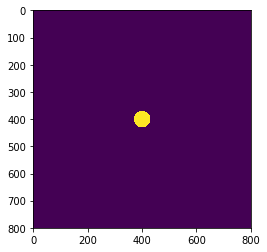

In [14]:
central_mask = np.zeros(newdata.shape)
xx, yy = np.meshgrid(np.arange(central_mask.shape[0]),np.arange(central_mask.shape[1]))
xc = newdata.shape[0]/2
yc = newdata.shape[1]/2
r = 30
central_mask_IDs = (xx-xc)**2+(yy-yc)**2 < r**2
plt.imshow(central_mask_IDs)